In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import time
from dateutil.relativedelta import relativedelta

%matplotlib inline
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# matplotlib.style.use('seaborn-paper')
import matplotlib.pyplot as plt

Part 1: construct basis indicators

In [4]:
os.chdir("../raw_data/")
df_future_price = pd.read_csv("CF_price.csv")
df_spot_price = pd.read_csv("CF_basis_spot.csv")

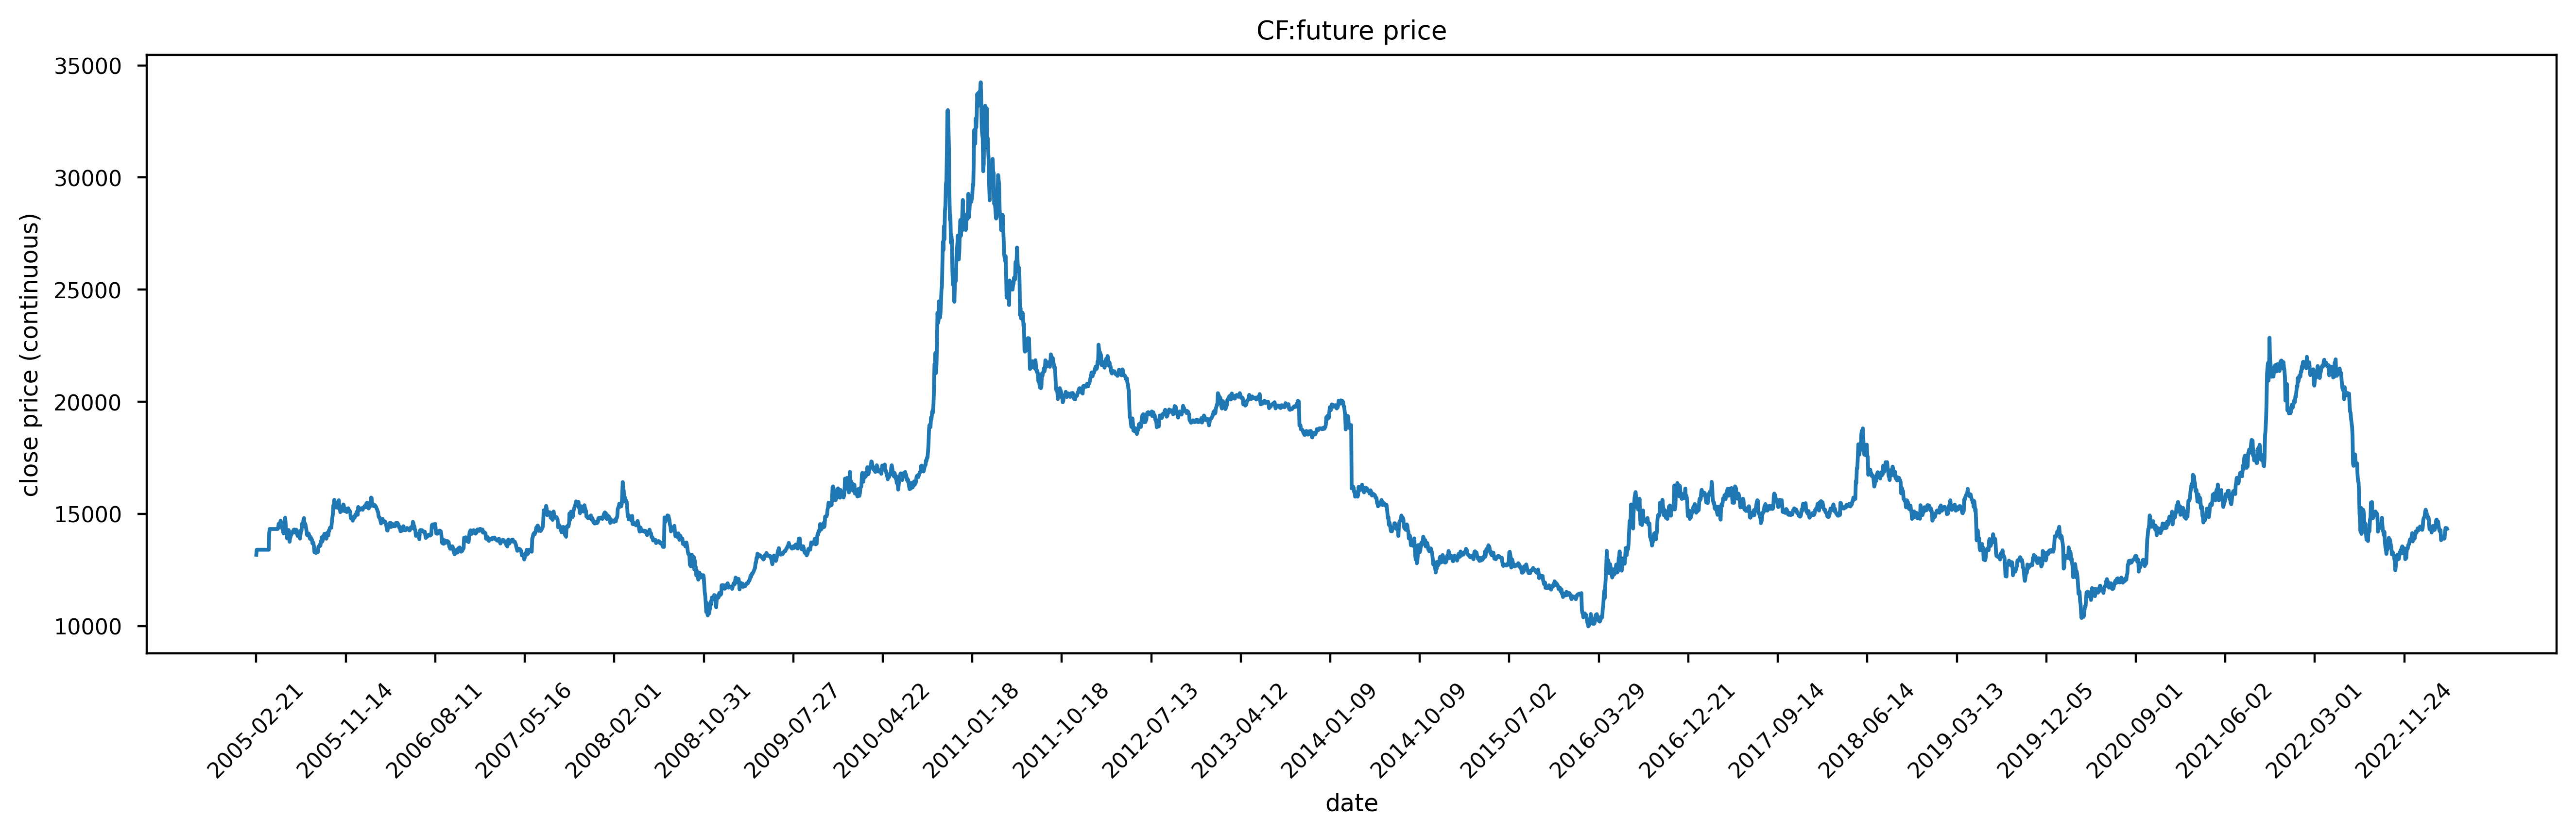

In [16]:
# visualize future close price

fig, ax = plt.subplots(dpi=400)

plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(df_future_price['CLOCK'], df_future_price['CLOSE'])

plt.xlabel("date")
plt.ylabel("close price (continuous)")

plt.xticks(rotation=45)
ax.set_xticks([x for x in range(0,len(df_future_price['CLOCK']),180)])

plt.title('CF:future price')

plt.show()

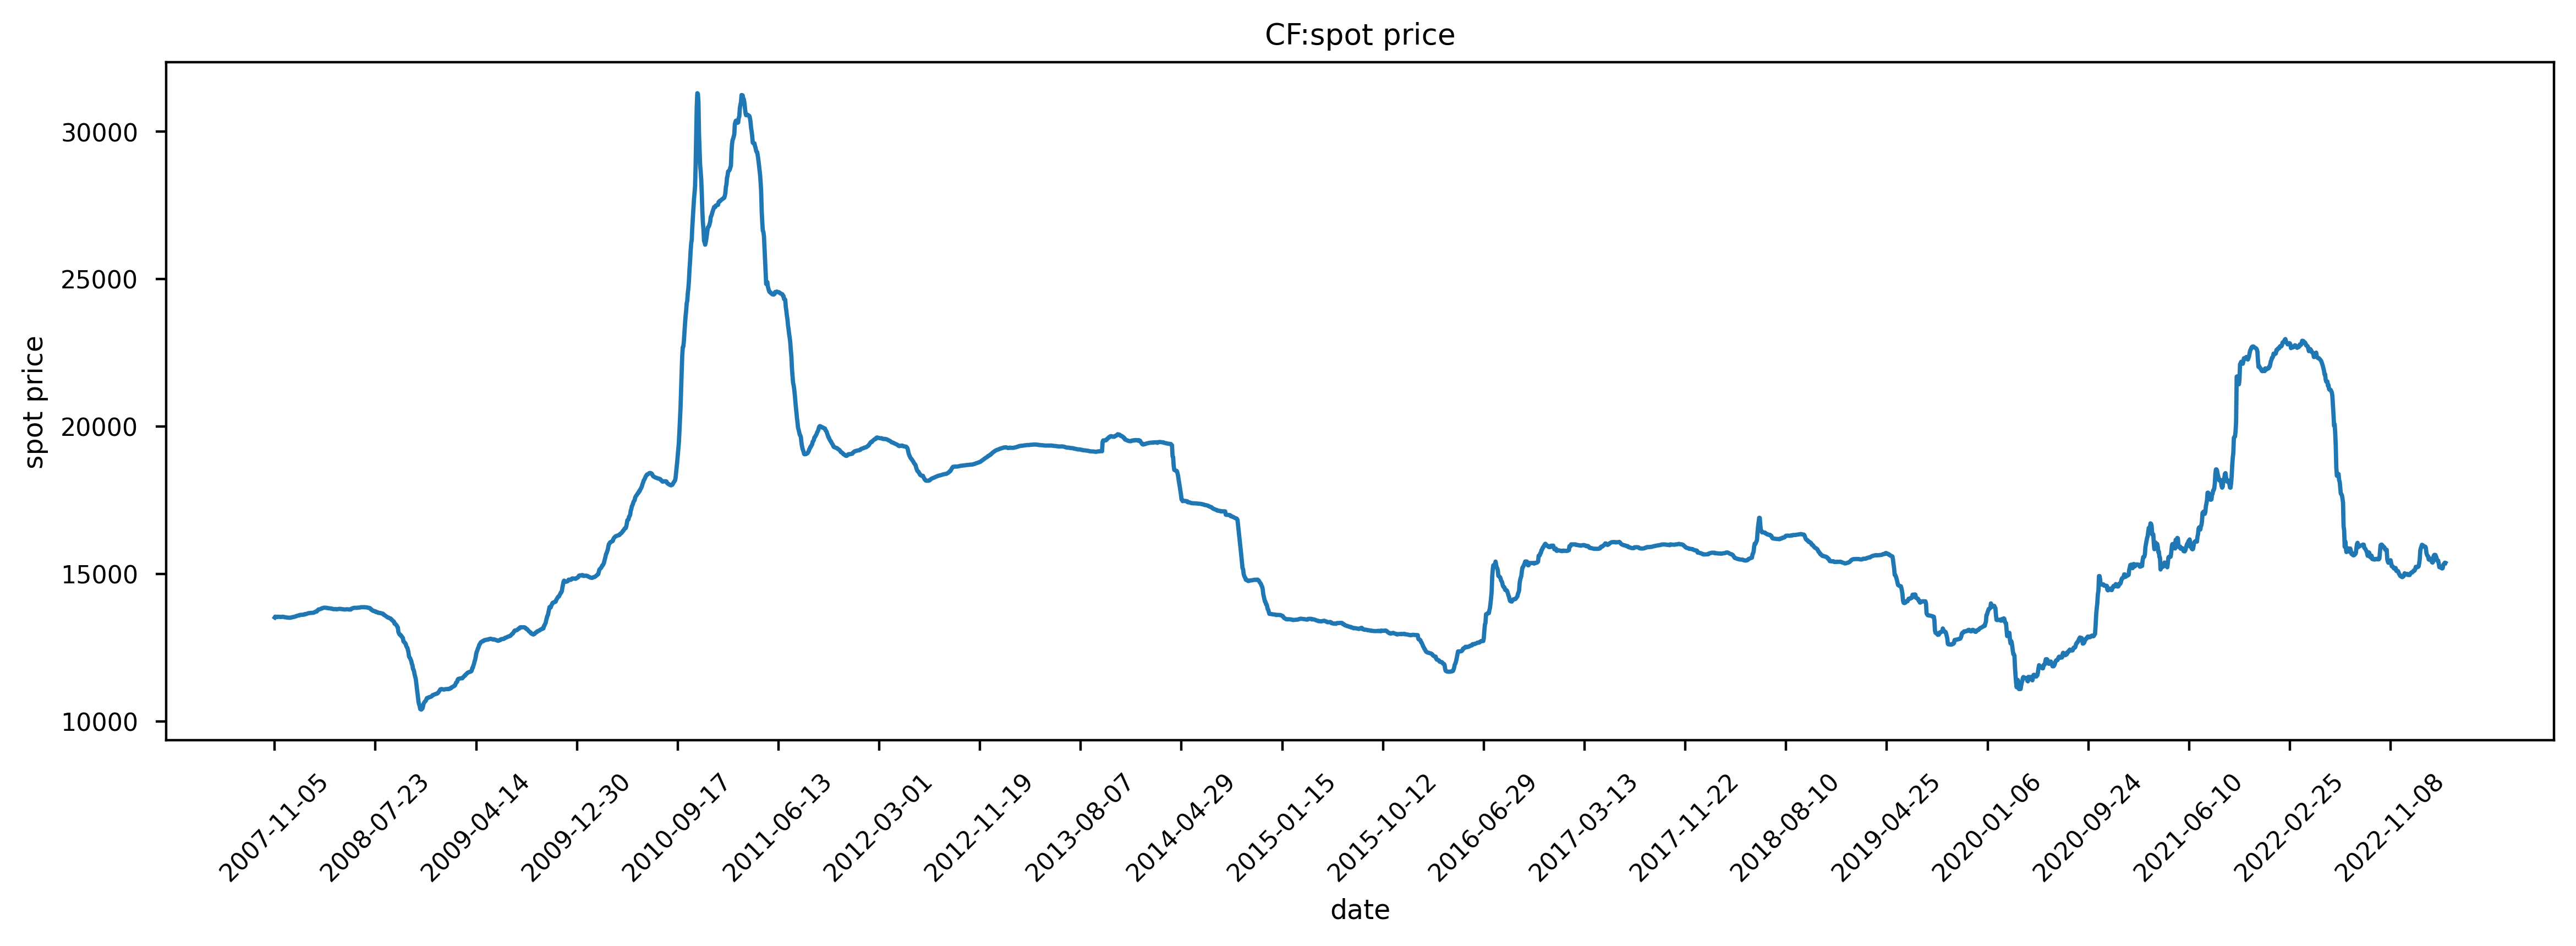

In [19]:
# visualize spot price
fig, ax = plt.subplots(dpi=400)

plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(df_spot_price['SymbolDate'], df_spot_price['SymbolVal'])

plt.xlabel("date")
plt.ylabel("spot price")

plt.xticks(rotation=45)
ax.set_xticks([x for x in range(0,len(df_spot_price['SymbolDate']),180)])

plt.title('CF:spot price')

plt.show()

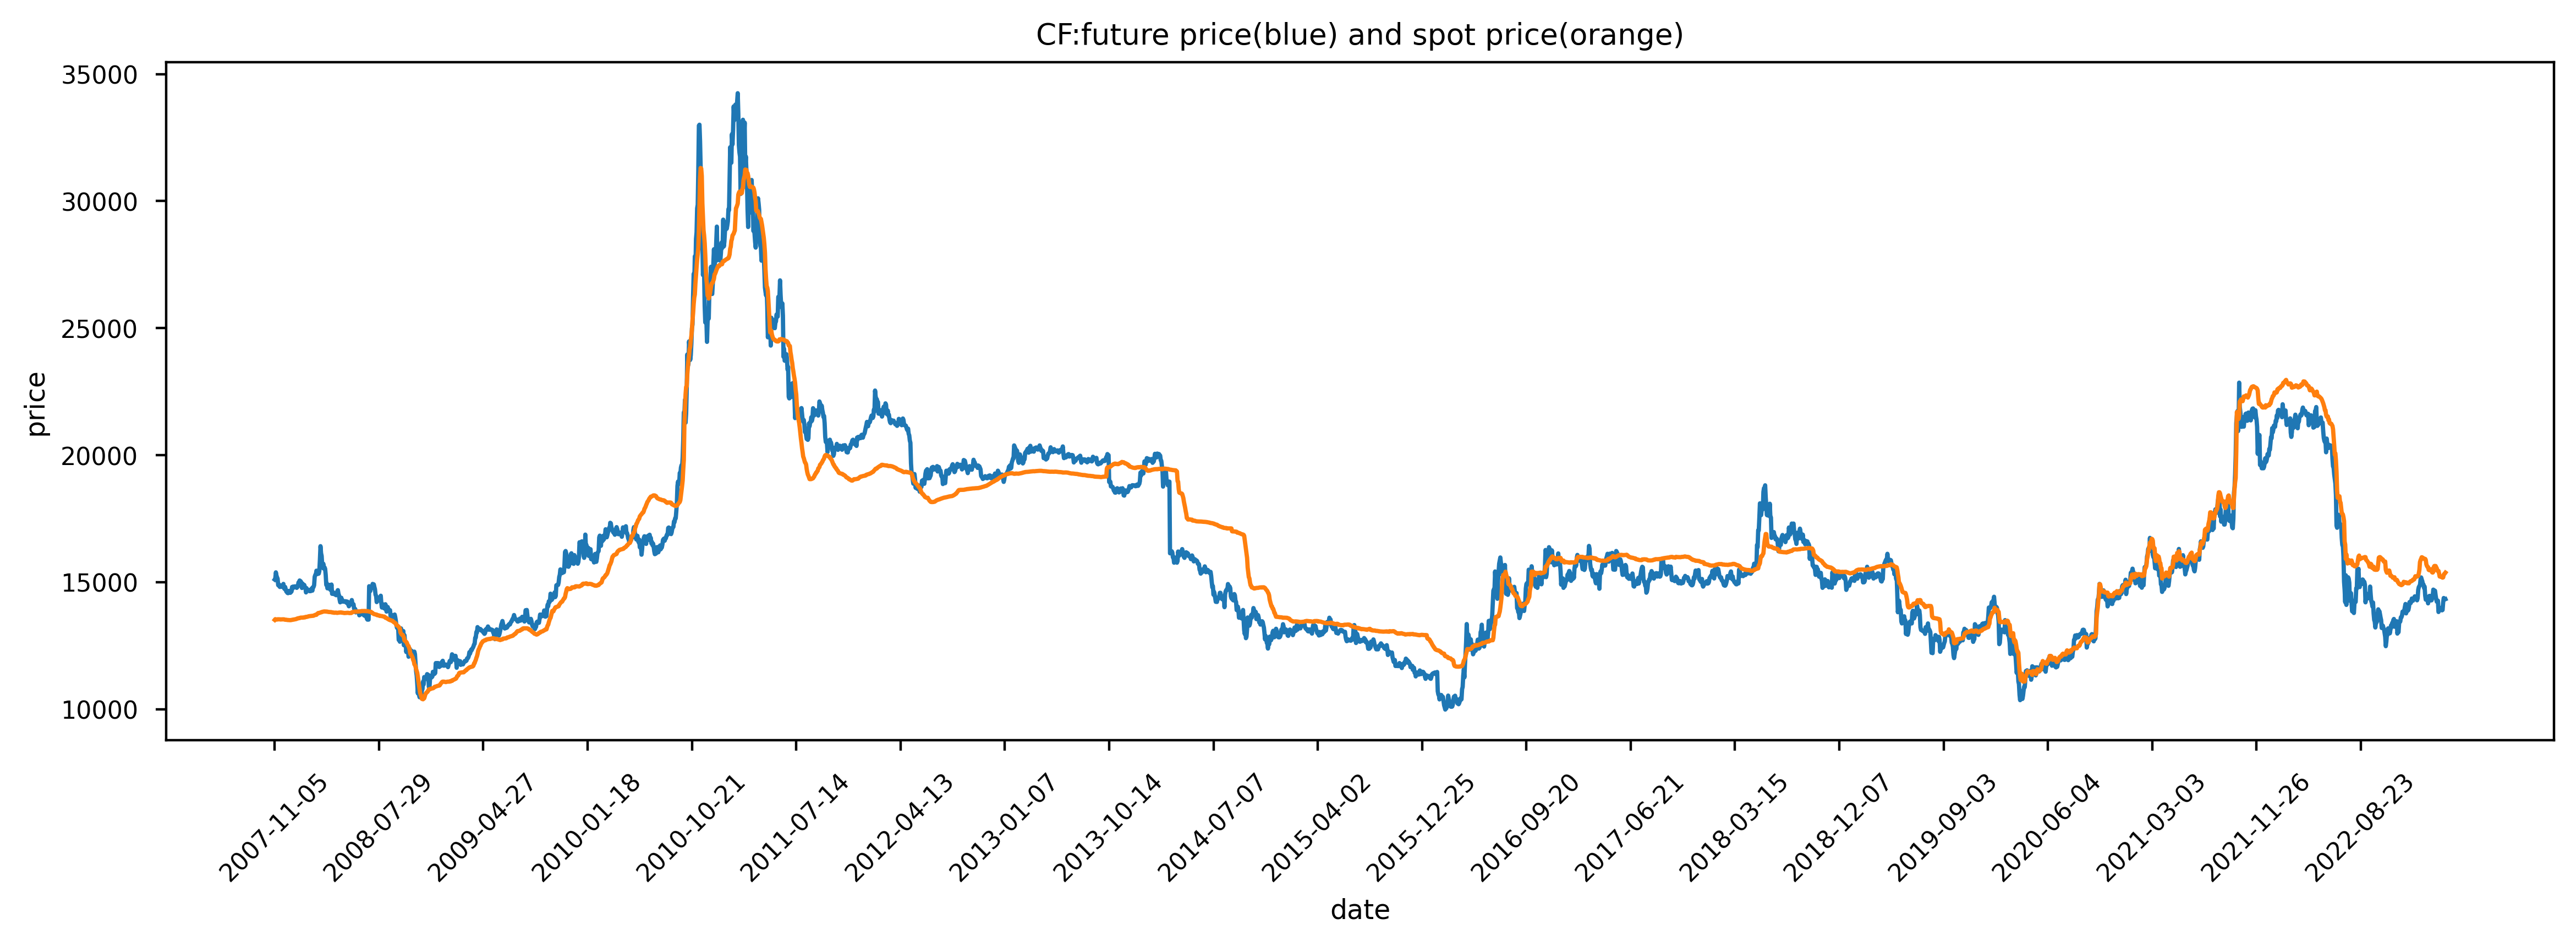

In [25]:
# merge spot price and future price to compute the basis
df_spot_part = df_spot_price[['SymbolDate', 'SymbolVal']]
df_future_part = df_future_price[['CLOCK', 'CLOSE']]
df_merge = df_future_part.merge(df_spot_part, left_on="CLOCK", right_on="SymbolDate")
df_merge = df_merge[['CLOCK', 'CLOSE', 'SymbolVal']]
df_merge.columns = ['date', 'futurePrice', 'spotPrice']

# visualize spot and future price
fig, ax = plt.subplots(dpi=400)

plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(df_merge['date'], df_merge['futurePrice'])
plt.plot(df_merge['date'], df_merge['spotPrice'])

plt.xlabel("date")
plt.ylabel("price")

plt.xticks(rotation=45)
ax.set_xticks([x for x in range(0,len(df_merge['date']),180)])

plt.title('CF:future price(blue) and spot price(orange)')

plt.show()

In [37]:
# generate train and test set for the model

# compute basis and shift it (consider the latency of spot price)
df_merge['basis'] = df_merge['spotPrice'] - df_merge['futurePrice']
df_merge['basis_shift'] = df_merge['basis'].shift(1)
print(df_merge.head(5))

df_input = df_merge[['date', 'basis_shift']].dropna()
df_input.columns = ['date', 'basis_indicator']

         date  futurePrice  spotPrice   basis  basis_shift
0  2007-11-05      15105.0    13519.0 -1586.0          NaN
1  2007-11-06      15135.0    13548.0 -1587.0      -1586.0
2  2007-11-07      15390.0    13533.0 -1857.0      -1587.0
3  2007-11-08      15265.0    13533.0 -1732.0      -1857.0
4  2007-11-09      15195.0    13533.0 -1662.0      -1732.0


In [48]:
# generate output: binary variable: not decrease (1) or decrease (0)
# gap_day is pre-defined
gap_day = 2 # the report uses 2, should try other values as well

df_output = df_future_price[['CLOCK', 'CLOSE']]
df_output['two_days_later_close'] = df_future_price['CLOSE'].shift(-gap_day)
df_output = df_output.dropna()
df_output['y'] = np.where((df_output['two_days_later_close'] - df_output['CLOSE']) >= 0, 1, 0)
df_output.columns = ['date', 'CLOSE', 'two_days_later_close', 'y']
df_output

,date,CLOSE,two_days_later_close,y
0,2005-02-21,13180.0,13405.0,1
1,2005-02-22,13405.0,13405.0,1
2,2005-02-23,13405.0,13405.0,1
3,2005-02-24,13405.0,13405.0,1
4,2005-02-25,13405.0,13405.0,1
...,...,...,...,...
4400,2023-03-24,13895.0,14205.0,1
4401,2023-03-27,13910.0,14380.0,1
4402,2023-03-28,14205.0,14325.0,1
4403,2023-03-29,14380.0,14325.0,0


In [50]:
# merge input and output
df_dataset = df_input.merge(df_output, on='date')
df_dataset = df_dataset[['date', 'basis_indicator', 'y']]
df_dataset

,date,basis_indicator,y
0,2007-11-06,-1586.0,1
1,2007-11-07,-1587.0,0
2,2007-11-08,-1857.0,0
3,2007-11-09,-1732.0,0
4,2007-11-12,-1662.0,0
...,...,...,...
3739,2023-03-24,1243.0,1
3740,2023-03-27,1319.0,1
3741,2023-03-28,1271.0,1
3742,2023-03-29,986.0,0


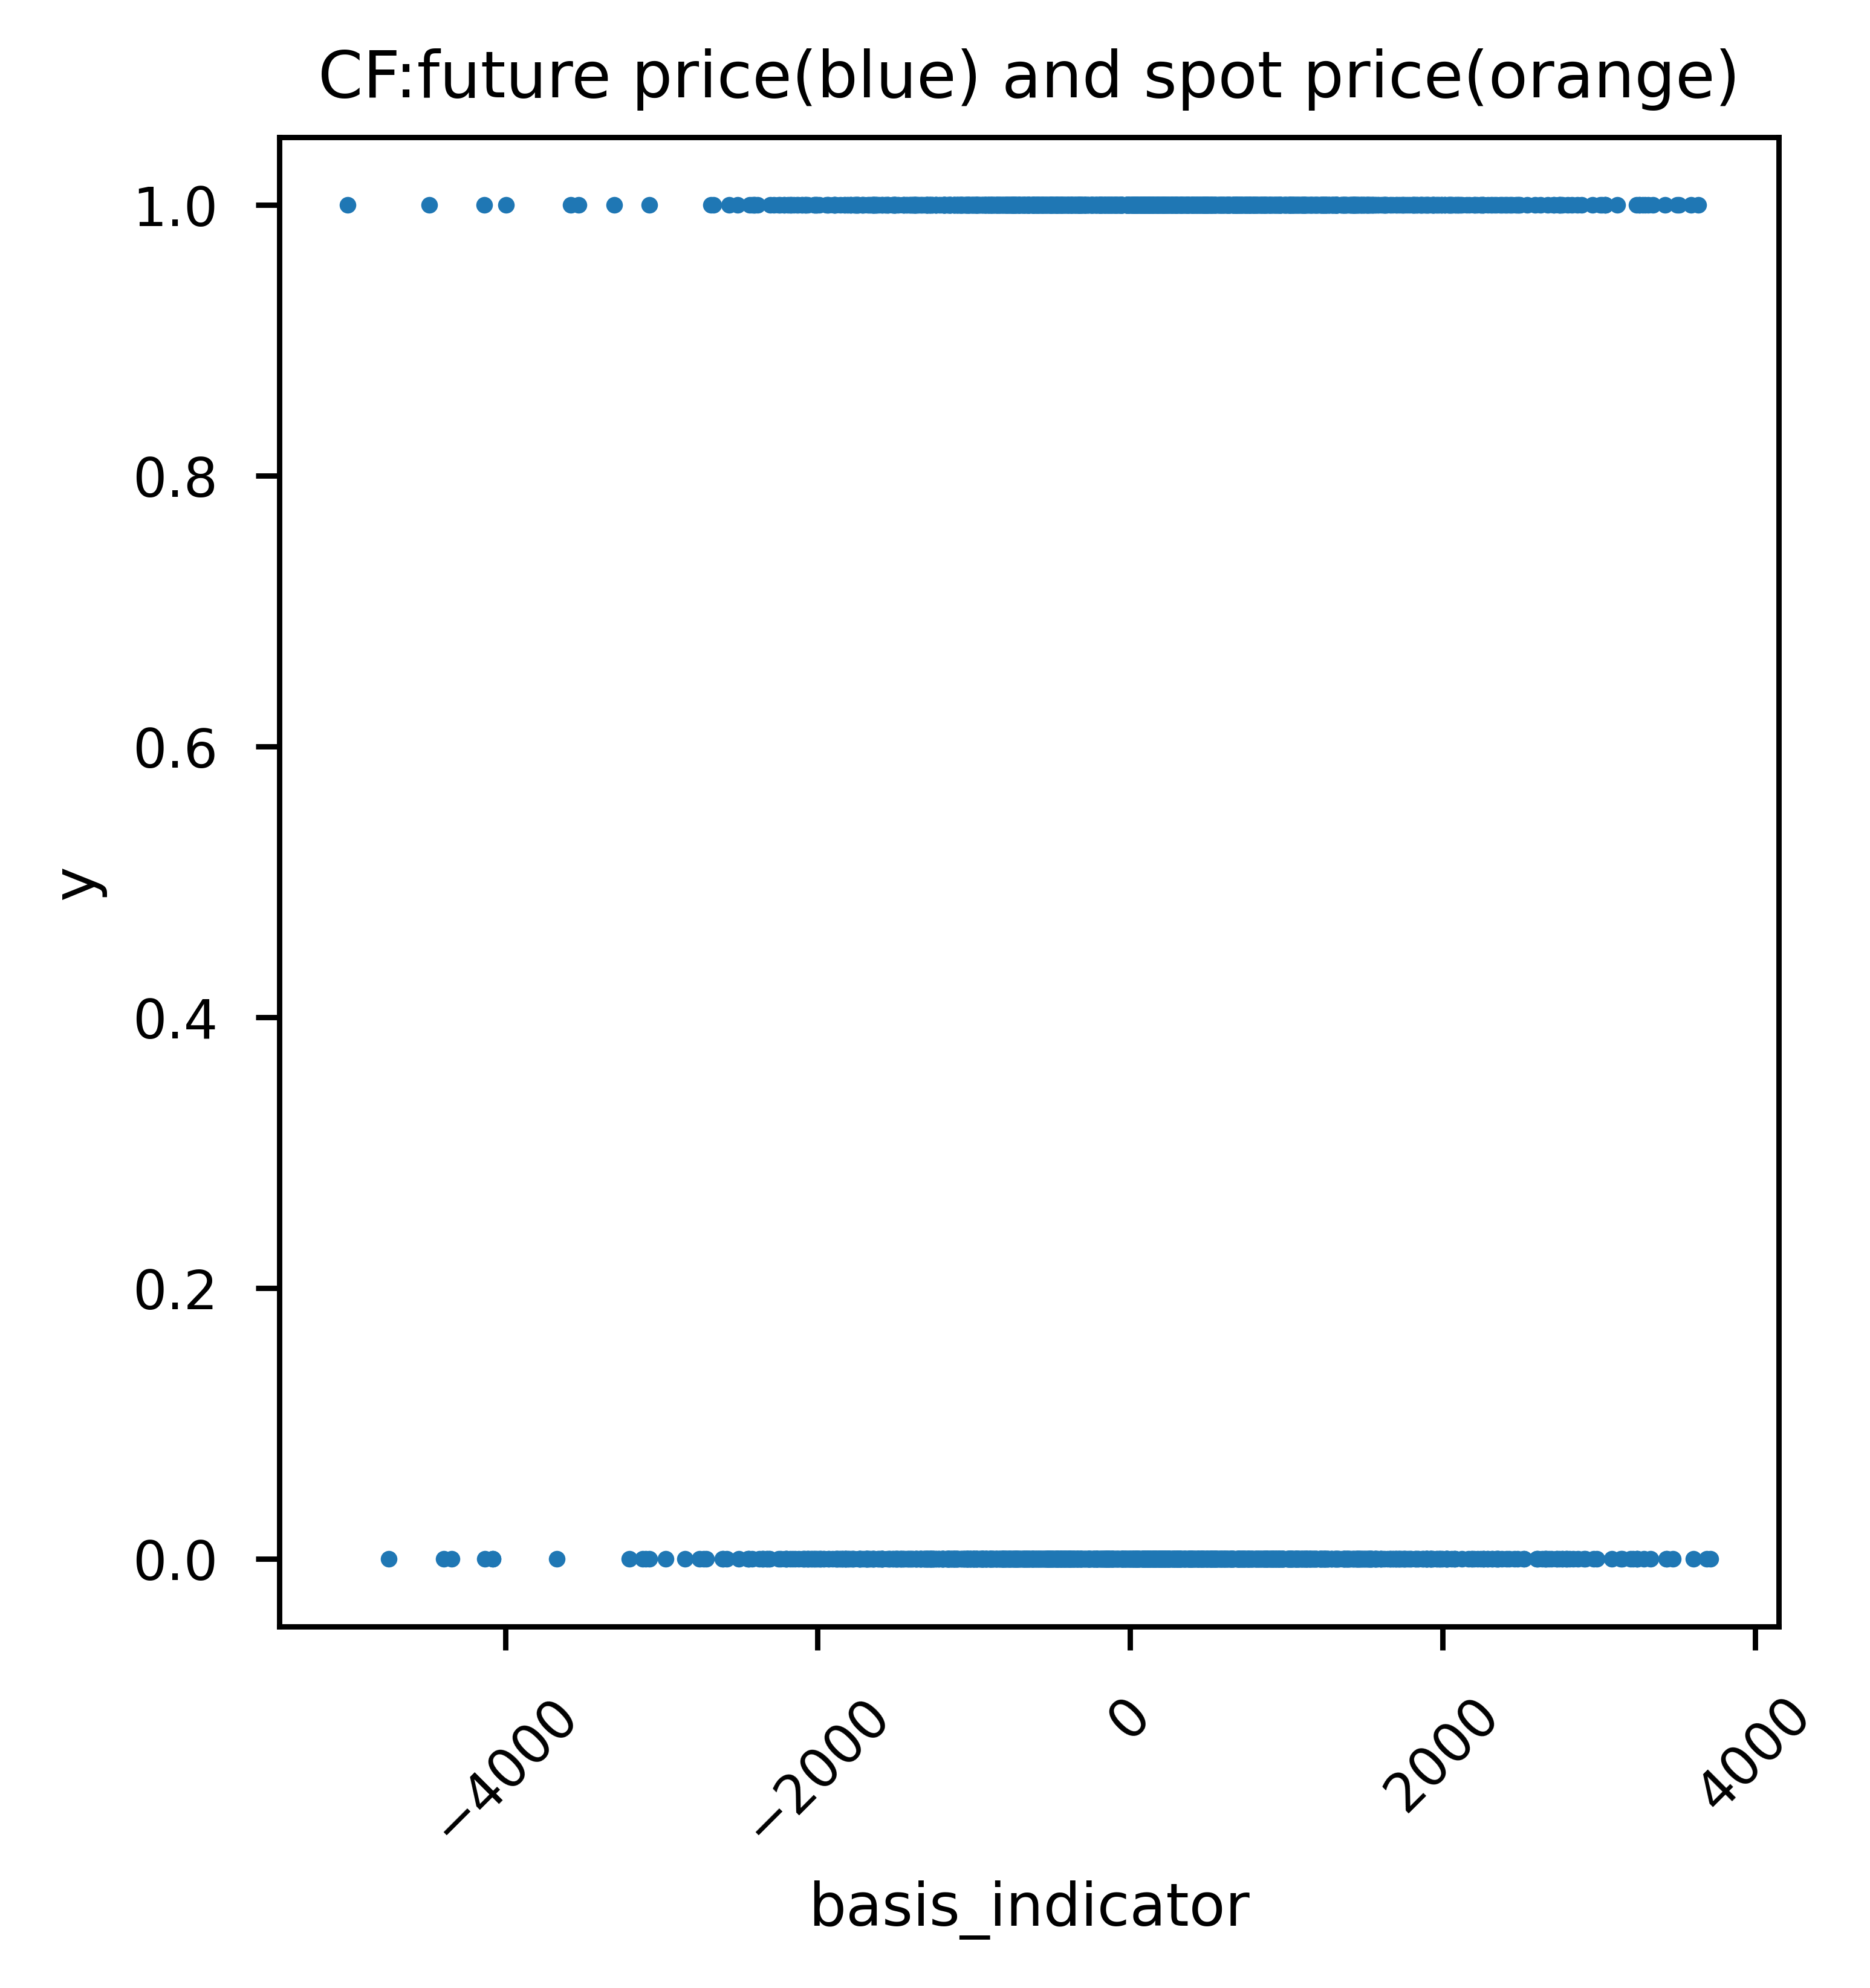

In [58]:
# scatter plot of x and y
fig, ax = plt.subplots(dpi=800)
plt.rcParams['figure.figsize'] = [4, 4]

plt.scatter(df_dataset['basis_indicator'], df_dataset['y'], s=5)

plt.xlabel("basis_indicator")
plt.ylabel("y")

plt.xticks(rotation=45)
# ax.set_xticks([x for x in range(0,len(df_merge['date']),180)])

plt.title('CF:future price(blue) and spot price(orange)')

plt.show()


In [60]:
# basis statistics
df_dataset['basis_indicator'].describe()

count    3744.000000
mean      120.186165
std      1078.441553
min     -5010.000000
25%      -567.250000
50%       134.000000
75%       773.750000
max      3715.000000
Name: basis_indicator, dtype: float64

In [61]:
df_dataset['y'].describe()

count    3744.000000
mean        0.510150
std         0.499964
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: y, dtype: float64

In [65]:
df_dataset

,date,basis_indicator,y
0,2007-11-06,-1586.0,1
1,2007-11-07,-1587.0,0
2,2007-11-08,-1857.0,0
3,2007-11-09,-1732.0,0
4,2007-11-12,-1662.0,0
...,...,...,...
3739,2023-03-24,1243.0,1
3740,2023-03-27,1319.0,1
3741,2023-03-28,1271.0,1
3742,2023-03-29,986.0,0


In [66]:
# save the dataset
os.chdir("../indicator_data/")
df_dataset.to_csv("dataset_basis.csv", index=False)